In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median
from rsi import apply as rsi

import pyfinancialdata
import trade_functions

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='AUD_JPY',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

In [3]:
# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])
environment_columns = ['rsi', 'price']

# Drop NA columns and reset index
price_data.dropna(inplace=True)

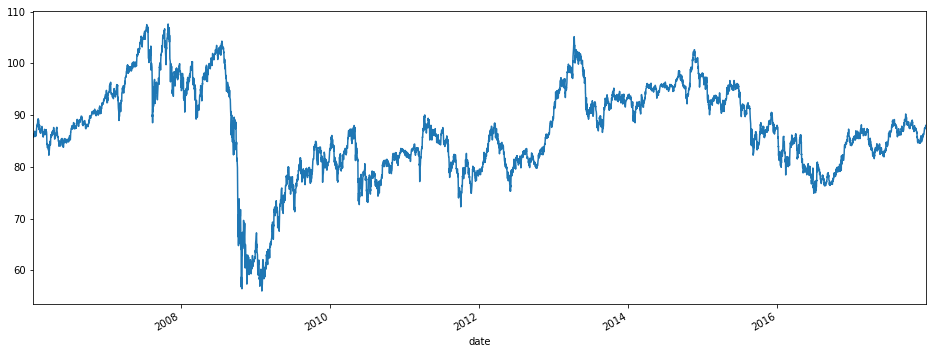

In [4]:
price_data['price'].plot(figsize=(16,6))

In [5]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 4663, test size 2332


In [6]:
episode=1000
batch_size=10

In [7]:
train_data.head(5)

,date,price,rsi
0,2006-01-10 00:00:00,86.03,42.772633
1,2006-01-10 12:00:00,85.79,38.421926
2,2006-01-11 00:00:00,86.03,44.473362
3,2006-01-11 12:00:00,86.33,50.931514
4,2006-01-12 00:00:00,85.78,41.459619


In [8]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 14550 pips, median trade count: 170
....................
episode: 40/1000
median profit: -55880 pips, median trade count: 213
....................
episode: 60/1000
median profit: -70700 pips, median trade count: 220
....................
episode: 80/1000
median profit: -70700 pips, median trade count: 236
....................
episode: 100/1000
median profit: -67940 pips, median trade count: 259
....................
episode: 120/1000
median profit: -67940 pips, median trade count: 250
....................
episode: 140/1000
median profit: -67940 pips, median trade count: 257
....................
episode: 160/1000
median profit: -61090 pips, median trade count: 236
....................
episode: 180/1000
median profit: -62510 pips, median trade count: 231
....................
episode: 200/1000
median profit: -58730 pips, median trade count: 215
....................
episode: 220/1000
median profit: -56000 pips, median trade count: 213
..

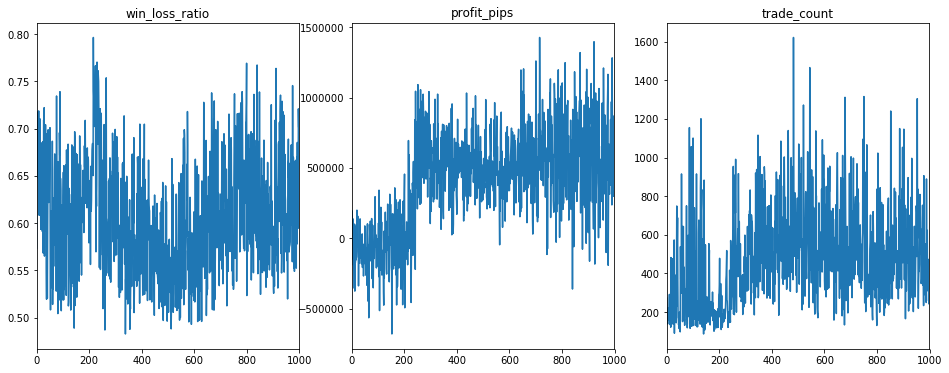

In [10]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [11]:
joblib.dump(agent, 'trained-model-AUD_JPY.pkl') 

['trained-model-AUD_JPY.pkl']

## Test

In [12]:
# Uncomment to load agent from file 
# agent = joblib.load('trained-model-AUD_JPY.pkl')  

In [13]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [14]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [15]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 167049.9999999977 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13808ea90>]],
      dtype=object)

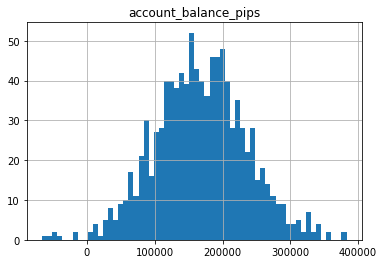

In [16]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

In [17]:
## Analyse positions on test data

In [18]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [19]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [20]:
env._stats()

{'trade_count': 96,
 'win_loss_ratio': 0.6354166666666666,
 'account_balance': 11.613999999999962,
 'unrealised_pl': -1.163000000000011}

In [21]:
position_data = env.price_data.copy()
position_data['position'] = position_data['position'] - 1
trades = trade_functions.create_trades_from_positions(position_data.copy())

98 positions to plot...


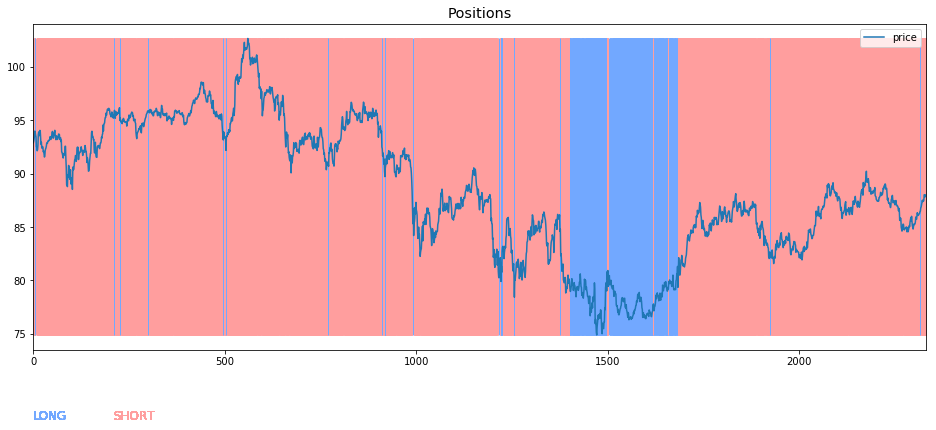

In [22]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [23]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 62.24%
Ratio of long to short positions: 1.16
Median profit: 0.38
Total profit: 10.45099999999995
Median position length: 4.0
Number of trades: 98


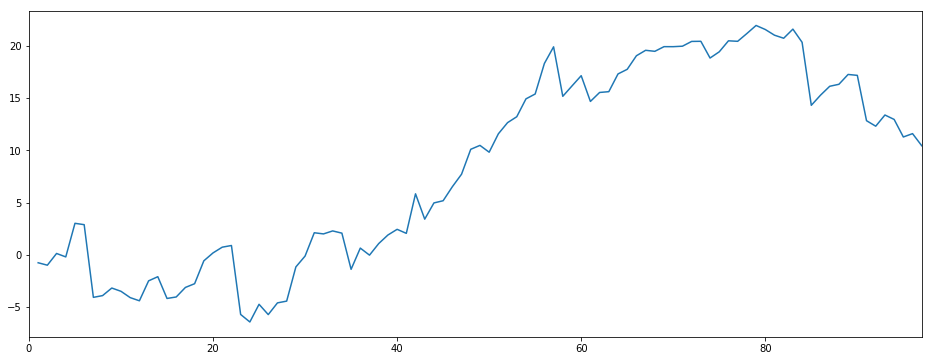

In [24]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -15.107000000000042


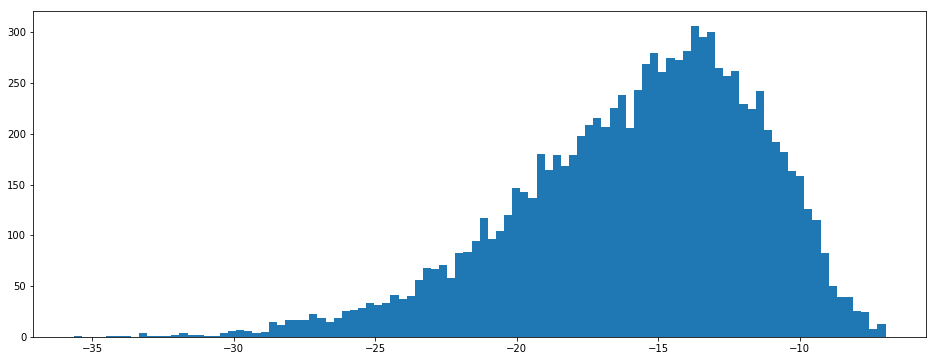

In [25]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);